In [3]:
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))



df = pd.read_csv(os.path.join(os.getcwd(), "../../data/total_4am.csv"), index_col=0)


In [4]:
from performance import get_performance


# Calculate the MACD and Signal line
def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    df['EMA12'] = df['close'].ewm(span=short_window, adjust=False).mean()
    df['EMA26'] = df['close'].ewm(span=long_window, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['signal_lane'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['signal_lane']
    return df

df = calculate_macd(df=df)

# Implement RSI strategy for long positions only
df['signal'] = 0  # Default to no position
for i in range(26, len(df)):
    # Buy condition
    if df.loc[i, "MACD_Histogram"] >= 0 and df.loc[i-1, "MACD_Histogram"] < 0:
        df.loc[i, 'signal'] = 1
    # Sell condition
    elif df.loc[i, "MACD_Histogram"] < 0 and df.loc[i-1, "MACD_Histogram"] >= 0:
        df.loc[i, 'signal'] = -1

# Manage positions
df['position'] = 0
holding_position = False

for i in range(1, len(df)):
    if df['signal'].iloc[i] == 1 and not holding_position:
        df.loc[i, 'position'] = 1
        holding_position = True
    elif df['signal'].iloc[i] == -1 and holding_position:
        df.loc[i, 'position'] = 0
        holding_position = False
    else:
        df.loc[i, 'position'] = df['position'].iloc[i-1]

# Calculate the strategy returns (only when in a long position)
df['strategy_returns'] = df['position'].shift(1) * df['close'].pct_change()

df['strategy_returns2'] = df['strategy_returns']

for i in range(1, len(df)):
    buy_price = df.loc[i-1, "close"]
    buy_price_copy = buy_price
    sell_price = df.loc[i, "close"]
    sell_price_copy = sell_price
    if df.loc[i-1, 'position'] == 1 and df.loc[i-1, 'signal'] == 1:
        # df.loc[i, 'strategy_returns2'] = (df.loc[i,'position'])/(df.loc[i-1, 'position'] * 1.002) -1
        buy_price = df.loc[i-1, "close"] * 1.002
    if df.loc[i, 'position'] == 0 and df.loc[i-1, 'position'] != 0:
        # df.loc[i, 'strategy_returns2'] = (df.loc[i,'position'] * 0.998)/(df.loc[i-1, 'position']) -1
        sell_price = df.loc[i, "close"] * 0.998
    
    if buy_price == buy_price_copy and sell_price == sell_price_copy:
        continue


    df.loc[i, "strategy_returns2"] = sell_price/buy_price - 1

df['cumulative_returns'] = (1 + df['strategy_returns']).cumprod()

df["cumulative_returns2"] = (1 + df['strategy_returns2']).cumprod()


# Calculate the benchmark cumulative returns (buy and hold strategy)
df['benchmark_returns'] = (1 + df['close'].pct_change()).cumprod()

# Save the results to a CSV file
df.to_csv(f"../../results/ma/macd_basic.csv")

# Get performance metrics and plot the results
get_performance(df=df, title=f"macd_basic")


======Investment Summary======
Strategy        : macd_basic
total_return    : 107.6
cagr            : 24.76
mdd             : 50.96
total_return_w_fee : 74.1
cagr_w_fee      : 18.29
mdd_w_fee       : 54.27
investing_days  : 1205


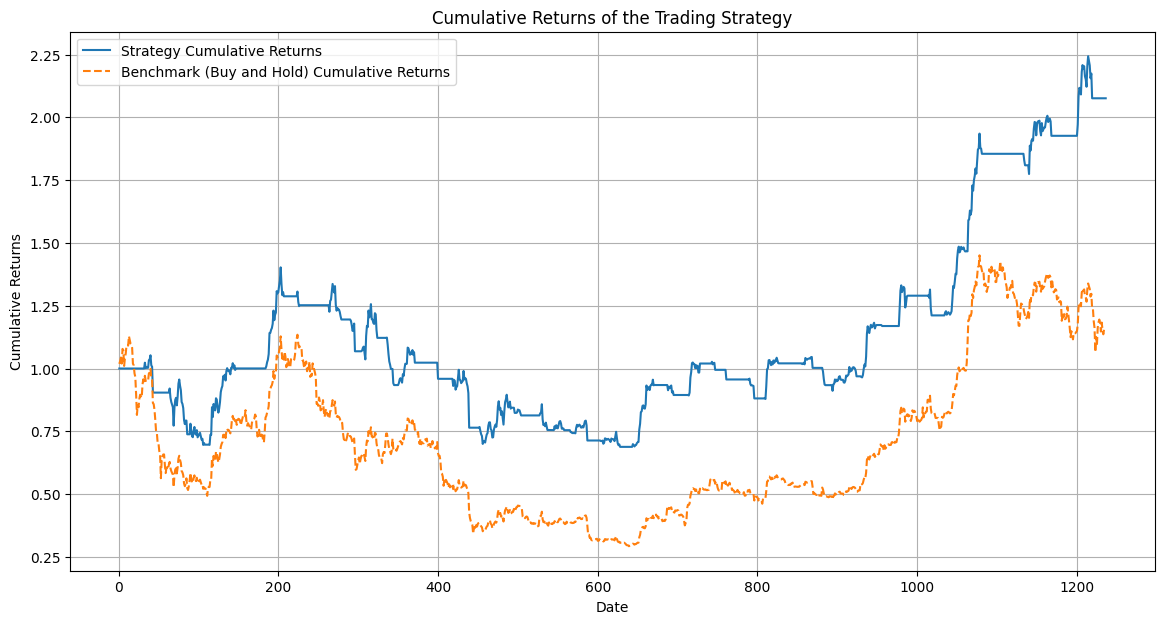

In [5]:
from performance import draw_graph

draw_graph(df)